In [11]:
# Prakash Patel
# Capston Project 1
# Predicting Property Prices in a Specific Location Using Machine Learning
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
from sklearn.model_selection import train_test_split
from pydantic import BaseModel
from typing import List, Dict




In [12]:
# Path to collected dataset
DATA_PATH = "Property_data.csv"

# Load data
df = pd.read_csv(DATA_PATH)


In [13]:
# Preview data
print("Shape of dataset:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

Shape of dataset: (1460, 81)

Columns:
 ['PropertyID', 'PropertyClass', 'PropertyZone', 'PropertyFrontage', 'PropertySize', 'Street', 'Alley', 'PropertyShape', 'Elevation', 'Amenities', 'Orientation', 'Grade', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'PropertyStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Roof1Material', 'Roof2Material', 'ExteriorCladdingType', 'ExteriorCladdingArea', 'ExterQual', 'ExterCond', 'PropertyFooting', 'BsmntFinish', 'BsmntMaintenance', 'BsmntVisibility', 'BsmntFinRat1', 'BsmntFinSty1', 'BsmntFinQual1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmntSqFtage', 'Heating', 'HeatingEfficiency', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'Bath1', 'Bath2', 'BedroomUpLev', 'KitchenUpLev', 'KitchenQual', 'CntRmsUpLev', 'Functional', 'CntFireplaces', 'QualFireplace', 'BasementType', 'BasementYrBlt', 'BasementFinish', 'BasementCars', 'BasementSqFootage',

In [14]:
# Step 2: Data Cleaning

# 1 Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing Values:\n", missing[missing > 0])

Missing Values:
 PoolQC                  1453
AddFeatures             1406
Alley                   1369
BoundaryFeatures        1179
ExteriorCladdingType     872
QualFireplace            690
PropertyFrontage         259
BasementYrBlt             81
BasementCond              81
BasementType              81
BasementFinish            81
BasementQual              81
BsmntFinQual1             38
BsmntVisibility           38
BsmntFinish               37
BsmntMaintenance          37
BsmntFinRat1              37
ExteriorCladdingArea       8
Electrical                 1
dtype: int64


In [15]:
# 2 Fill missing values
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())


In [16]:
# Categorical → mode (most frequent value)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\n Missing values handled.")


 Missing values handled.


In [17]:
# 3) Handle outliers (using IQR method for numeric columns)
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df[col] = np.where(df[col] < lower, lower, df[col])   # clip lower
    df[col] = np.where(df[col] > upper, upper, df[col])   # clip upper

print(" Outliers capped using IQR method.")

 Outliers capped using IQR method.


In [18]:
# 4) Ensure correct data types
df = df.convert_dtypes()
print(" Data types fixed.")


 Data types fixed.


In [19]:
# Final check
print("\nCleaned Data Shape:", df.shape)
print(df.info())


Cleaned Data Shape: (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PropertyID            1460 non-null   Int64  
 1   PropertyClass         1460 non-null   Int64  
 2   PropertyZone          1460 non-null   string 
 3   PropertyFrontage      1460 non-null   Float64
 4   PropertySize          1460 non-null   Float64
 5   Street                1460 non-null   string 
 6   Alley                 1460 non-null   string 
 7   PropertyShape         1460 non-null   string 
 8   Elevation             1460 non-null   string 
 9   Amenities             1460 non-null   string 
 10  Orientation           1460 non-null   string 
 11  Grade                 1460 non-null   string 
 12  Neighborhood          1460 non-null   string 
 13  Condition1            1460 non-null   string 
 14  Condition2            1460 non-null   st

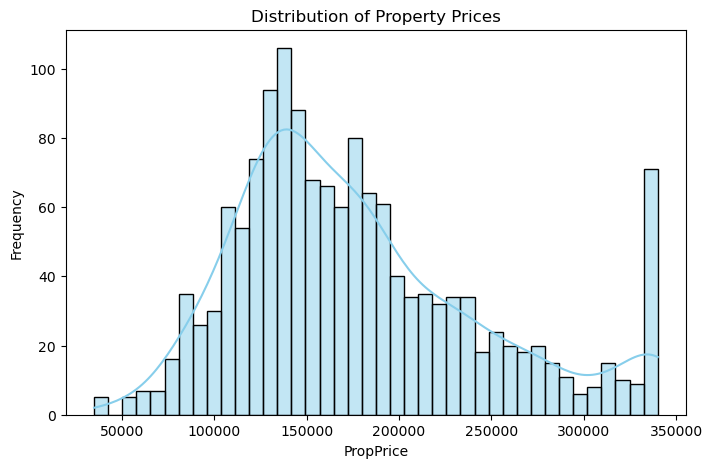

In [29]:
# EDA
# 1 Target Distribution
TARGET = "PropPrice"
plt.figure(figsize=(8,5))
sns.histplot(df[TARGET], bins=40, kde=True, color="skyblue")
plt.title("Distribution of Property Prices")
plt.xlabel("PropPrice")
plt.ylabel("Frequency")
plt.show()



Top correlations with Price:
 PropPrice            1.000000
TotalSF              0.821885
OverallQual          0.817680
GrLivArea            0.729311
BasementCars         0.675896
BasementSqFootage    0.660029
BsmntSqFtage         0.645251
TotalBathrooms       0.622524
Name: PropPrice, dtype: float64


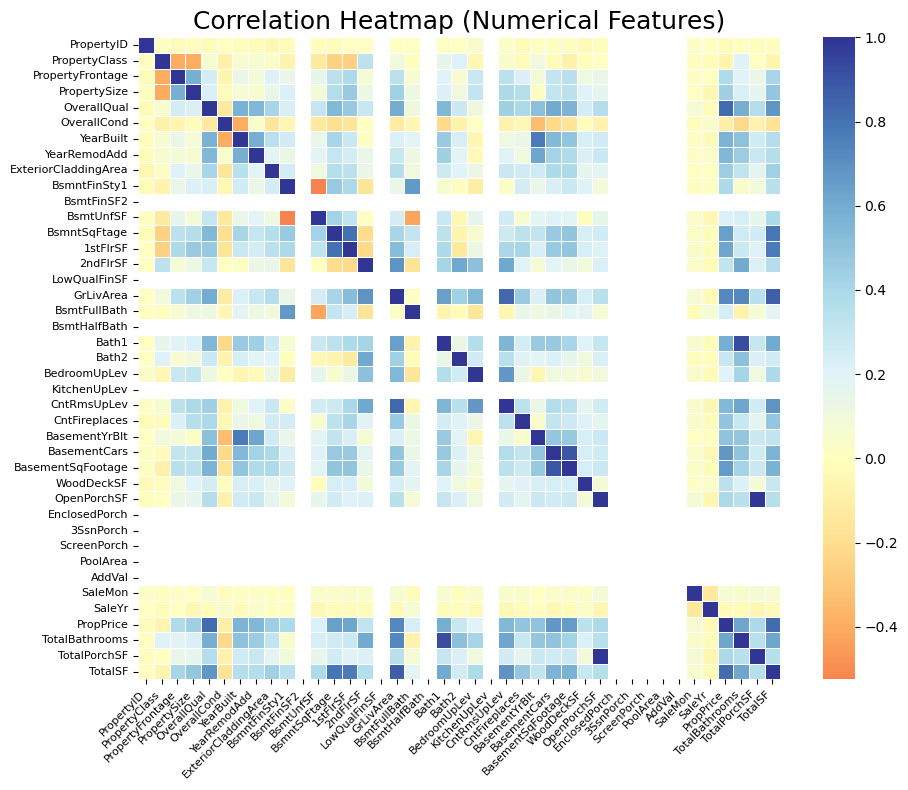

In [41]:

# === 3) Correlation Analysis (Numerical Features)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Correlation with target
corr = df[num_cols].corr()[TARGET].sort_values(ascending=False)
print("\nTop correlations with Price:\n", corr.head(8))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[num_cols].corr(),
    cmap="RdYlBu",   # Red → Yellow → Blue color scheme
    center=0,
    annot=False,     # remove numbers inside
    cbar=True,
    square=True,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Correlation Heatmap (Numerical Features)", fontsize=18)
plt.xticks(fontsize=8, rotation=45, ha="right")
plt.yticks(fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

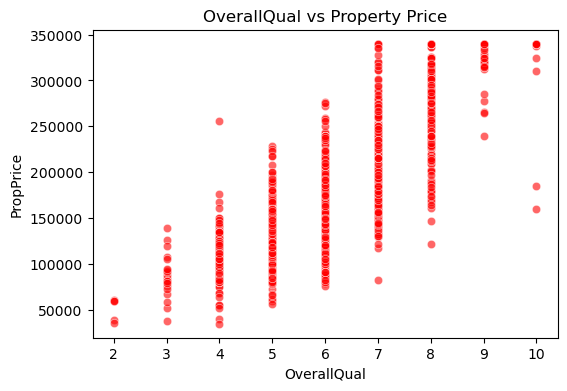

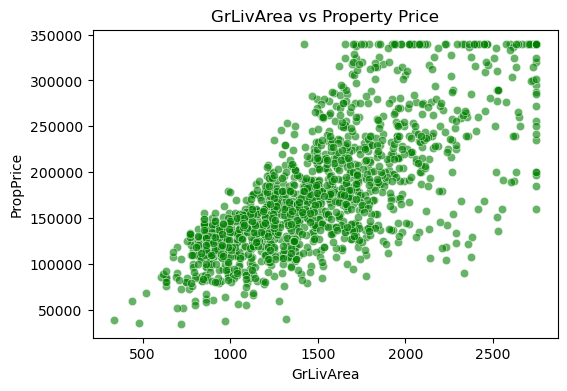

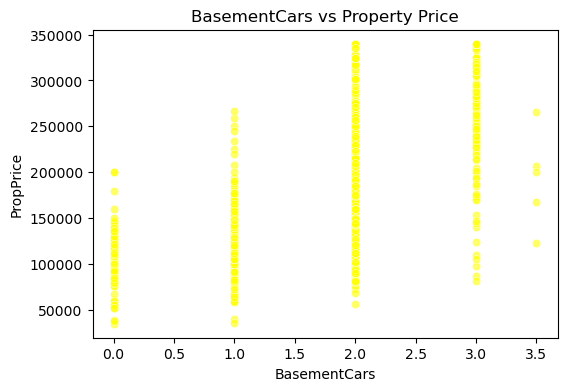

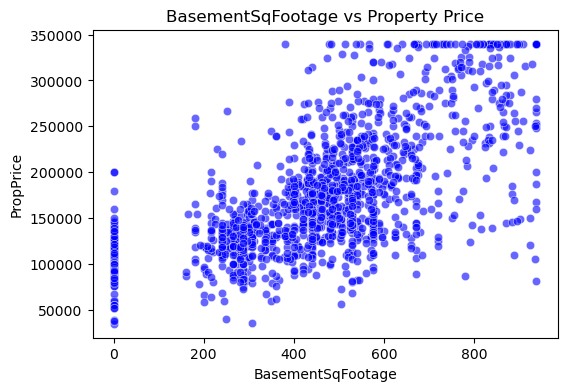

In [32]:
# 3) Price vs Key Numeric Predictors
colors = ["red", "green", "yellow", "Blue"]

top_corr_features = corr.drop(TARGET).head(4).index.tolist()

for i, col in enumerate(top_corr_features):
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x=df[col], 
        y=df[TARGET], 
        alpha=0.6, 
        color=colors[i % len(colors)]  # cycle through red, green, yellow
    )
    plt.title(f"{col} vs Property Price")
    plt.show()


In [33]:
cat_cols = df.select_dtypes(include='object').columns[:4]  # first 4 categoricals
for col in cat_cols:
    sns.boxplot(x=col, y=TARGET, data=df)
    plt.xticks(rotation=45)
    plt.title(f"{col} vs Property Price")
    plt.show()


Top 10 Important Features (RandomForest):
 OverallQual          0.601642
GrLivArea            0.112720
BsmntSqFtage         0.043215
BasementCars         0.033470
BasementSqFootage    0.025282
BsmntFinSty1         0.024012
1stFlrSF             0.018128
PropertySize         0.011532
YearBuilt            0.010503
YearRemodAdd         0.006987
dtype: float64


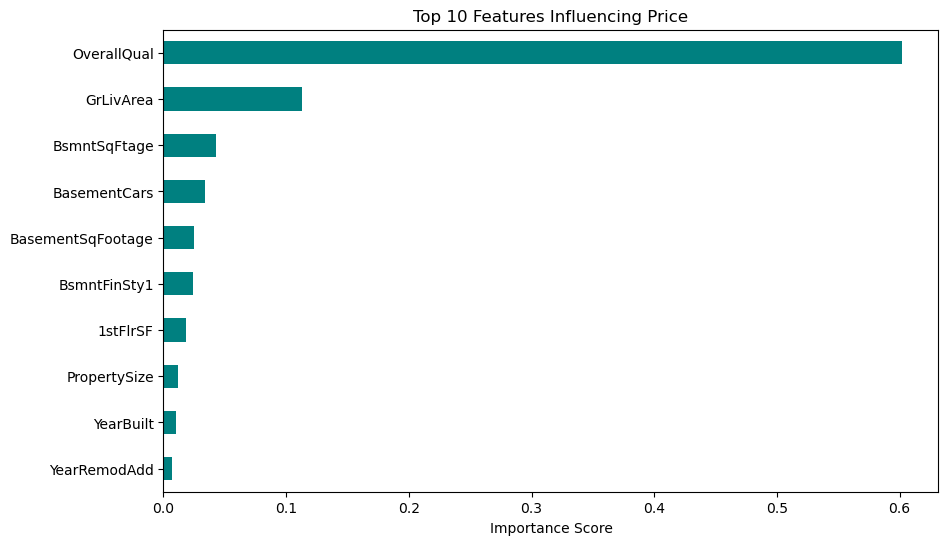

In [35]:
# 5) Quick Feature Importance (RandomForest)

# Drop NA just for quick importance estimation
df_ml = df.dropna(subset=[TARGET])
X = df_ml.drop(columns=[TARGET])
y = df_ml[TARGET]

X_enc = pd.get_dummies(X, drop_first=True)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_enc, y)

importances = pd.Series(rf.feature_importances_, index=X_enc.columns).sort_values(ascending=False)
print("\nTop 10 Important Features (RandomForest):\n", importances.head(10))

plt.figure(figsize=(10,6))
importances.head(10).iloc[::-1].plot(kind="barh", color="teal")
plt.title("Top 10 Features Influencing Price")
plt.xlabel("Importance Score")
plt.show()

In [36]:
# Create New Features
if "YearBuilt" in df.columns and "YrSold" in df.columns:
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]

if "YearRemodAdd" in df.columns and "YrSold" in df.columns:
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]

bath_cols = [c for c in ["Bath1","Bath2","BsmtBath1","BsmtBath2"] if c in df.columns]
if len(bath_cols) > 0:
    df["TotalBathrooms"] = (
        df.get("Bath1",0) +
        0.5*df.get("Bath2",0) +
        df.get("BsmtBath1",0) +
        0.5*df.get("BsmtBath2",0)
    )

porch_cols = [c for c in ["OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"] if c in df.columns]
if len(porch_cols) > 0:
    df["TotalPorchSF"] = df[porch_cols].sum(axis=1)

if all(c in df.columns for c in ["1stFlrSF","2ndFlrSF","BsmntSqFtage"]):
    df["TotalSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["BsmntSqFtage"]

print(" New domain features added.")


 New domain features added.


In [345]:
# Encoding Setup
TARGET = "PropPrice"

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in numeric_features: numeric_features.remove(TARGET)

categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()


In [346]:
# Example ordinal mappings (only if present)
ordinal_maps = {
    "ExterQual": ["Ex","Gd","TA","Fa","Po"],
    "KitchenQual": ["Ex","Gd","TA","Fa","Po"],
    "Functional": ["Typ","Min1","Min2","Mod","Maj1","Maj2","Sev","Sal"],
    "PavedDrive": ["Y","P","N"]
}
ordinal_cols = [c for c in ordinal_maps if c in df.columns]
nominal_cols = [c for c in categorical_features if c not in ordinal_cols]


In [348]:
# Preprocessors
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ordinal_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=[ordinal_maps[c] for c in ordinal_cols],
                               handle_unknown="use_encoded_value", unknown_value=-1))
])

try:
    nominal_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    nominal_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

preprocessor = ColumnTransformer([
    ("num", numeric_tf, numeric_features),
    ("ord", ordinal_tf, ordinal_cols),
    ("nom", nominal_tf, nominal_cols)
])

print(" Feature engineering pipeline prepared.")

 Feature engineering pipeline prepared.


In [349]:
# Train/Test Split
TARGET = "PropPrice"
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [352]:
# Candidate Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}


In [353]:
# Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
trained_models = []

for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    cv = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="r2")
    pipe.fit(X_train, y_train)
    results.append([name, cv.mean(), cv.std()])
    trained_models.append((name, pipe))
    print(f"{name:15} | CV R² = {cv.mean():.3f} ± {cv.std():.3f}")

LinearRegression | CV R² = -3323900186391056384.000 ± 4252874297585331712.000
Ridge           | CV R² = 0.889 ± 0.012
DecisionTree    | CV R² = 0.762 ± 0.047
RandomForest    | CV R² = 0.886 ± 0.011
GradientBoosting | CV R² = 0.906 ± 0.011


In [354]:
# Results DataFrame
results_df = pd.DataFrame(results, columns=["Model","CV_R2_mean","CV_R2_std"]).sort_values("CV_R2_mean", ascending=False)
print("\nModel Comparison:\n", results_df)


Model Comparison:
               Model    CV_R2_mean     CV_R2_std
4  GradientBoosting  9.059440e-01  1.147831e-02
1             Ridge  8.887661e-01  1.196311e-02
3      RandomForest  8.857705e-01  1.086082e-02
2      DecisionTree  7.623741e-01  4.685192e-02
0  LinearRegression -3.323900e+18  4.252874e+18


In [355]:
best_pipe = Pipeline([
    ("preprocess", preprocessor),    # from Step 4
    ("model", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
])

# Train Model
best_pipe.fit(X_train, y_train)

# Test Model
y_pred = best_pipe.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("\n Final Model Evaluation on Test Set")
print(f"R² Score : {r2:.3f}")
print(f"MAE      : {mae:.2f}")
print(f"RMSE     : {rmse:.2f}")

# -------------------------
# Save Trained Model for Deployment
# -------------------------
MODEL_PATH = "best_model.joblib"
joblib.dump(best_pipe, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 Final Model Evaluation on Test Set
R² Score : 0.918
MAE      : 13590.44
RMSE     : 20035.93
Model saved to best_model.joblib


In [356]:

# Evaluate the trained model
y_pred = best_pipe.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Model Performance on Test Set")
print(f"R² Score : {r2:.3f}")
print(f"MAE      : {mae:.2f}")
print(f"RMSE     : {rmse:.2f}")


Model Performance on Test Set
R² Score : 0.918
MAE      : 13590.44
RMSE     : 20035.93


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


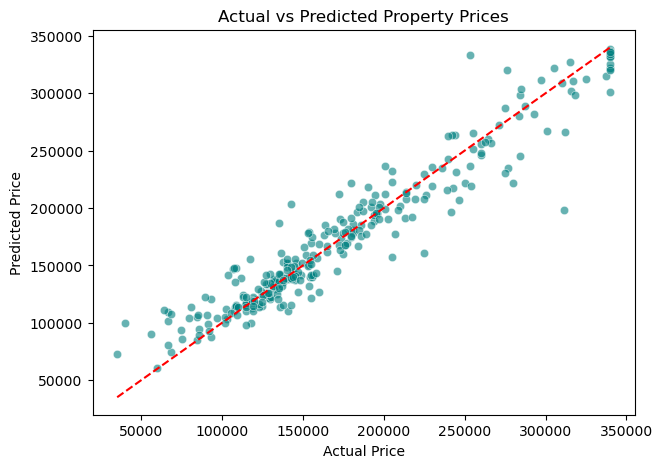

In [367]:
# Plot Actual vs Predicted
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="teal")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.title("Actual vs Predicted Property Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()


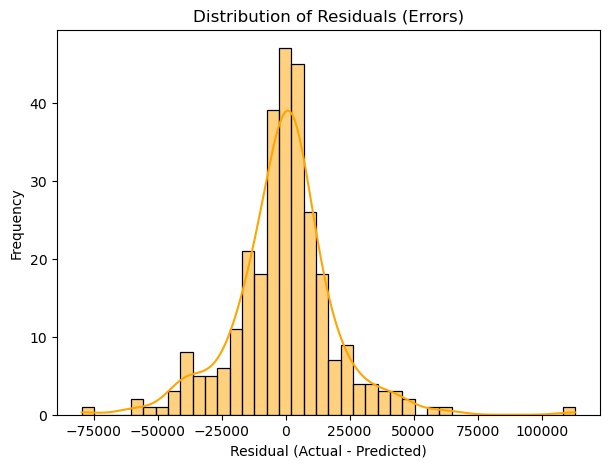

In [358]:
# Residual Distribution
residuals = y_test - y_pred
plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=40, kde=True, color="orange")
plt.title("Distribution of Residuals (Errors)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

In [388]:
from fastapi import FastAPI

# Load Trained Model
MODEL_PATH = "best_model.joblib"   # <-- saved in Step 6
pipe = joblib.load(MODEL_PATH)

# Initialize FastAPI App
app = FastAPI(
    title=" Property Price Prediction API",
    description="API that predicts property prices using ML model",
    version="1.0"
)

# Define Schema for Input
class Record(BaseModel):
    __root__: Dict[str, object]   # each record is a dict of property features

@app.post("/predict")
def predict(records: List[Record]):
    # Convert JSON into DataFrame
    data = [rec.__root__ for rec in records]
    X = pd.DataFrame(data)

    # Predict using pipeline
    preds = pipe.predict(X).tolist()

    return {"predictions": preds}

ModuleNotFoundError: No module named 'fastapi'